## PID制御

### 連続時間の式
$$
\begin{aligned}
e(t) &= r(t) - y(t)\\
u(t) &= \underbrace{\vphantom{\int} K_pe(t)}_{比例P} + \underbrace{K_i\int_0^t e(\tau)d\tau}_{積分I} + \underbrace{\vphantom{\int} K_d\dot{e}(t)}_{微分D} \\
y(t) &= \int_0^t u(t) d\tau \\
\end{aligned}
$$

### 離散時間の式
$$
\begin{aligned}
e_{k} &= r_{k} - y_{k-1} \\
u_{k} &= K_p e_{k} + K_i \sum_0^n e_{n} + K_d \frac{ e_{k} - e_{k-1} }{dt} \\
\end{aligned}
$$

### モデルの仮定 (2次系)
制御量$u(t)$に速度$v(t)$が$\tau = 150 \,\mathrm{ms}$の一次遅れで応答する物体の、変位$y(t) = \int v(t) dt$を目標値に追従させる。

制御器の都合から制御量の最大値を$u_{\mathrm{max}} = 0.7$として$|u(t)| < u_{\mathrm{max}}$とする。
また出力の非線形性と静止摩擦を考慮して$|u(t)| < 0.1$のとき$u(t) \simeq 0$とする。

このとき離散時間におけるモデルの速度、変位はそれぞれ次の式で表せる。

$$
\begin{aligned}
v_{k} &= v_{k-1} + (v_{k-1} - u_{k}) \frac{1}{16} \\
y_{k} &= y_{k-1} + v_{k} dt \\
\end{aligned}
$$

### 改良版PID制御 (目標値フィルタ + anti-windup + 不完全微分)
追従速度$v_{\mathrm{ref}} = 0.8 \,\mathrm{m/s}$として、目標値の移動を線形補間する。

I値の飽和によるwindupを防ぐため、anti-windupとしてI値にもsaturationを実装する。

キックを防ぐためD項にローパスフィルタを加え、不完全微分とする。

制御量にもローパスフィルタを加え、出力の急変を抑える。

$$
\operatorname{clamp}(x, \mathrm{lo}, \mathrm{high}) = \begin{cases}
\mathrm{high} & \text{if}\ x > \mathrm{high} \\
\mathrm{lo} & \text{if}\ x >\mathrm{lo} \\
x & \text{otherwise} \\
\end{cases} \\
$$

上記の関数を定義して

$$
\begin{aligned}
\mathrm{tag}_{k} &= \mathrm{tag}_{k-1} + \operatorname{clamp}(\mathrm{tag}_{k-1} + r_{k},\ -v_{\mathrm{ref}} dt,\ v_{\mathrm{ref}} dt) \\
e_{k} &= \mathrm{tag}_{k} - y_{k-1} \\
I_{k} &= \begin{cases}
\operatorname{clamp}(e_{k} dt,\ -u_{\mathrm{max}} / K_i,\ u_{\mathrm{max}} / K_i) & (k = 0) \\
\operatorname{clamp}(I_{k-1} + e_{k} dt,\ -u_{\mathrm{max}} / K_i,\ u_{\mathrm{max}} / K_i) & (k \ne 0) \\
\end{cases} \\
D_{k} &= \begin{cases}
0 & (k = 0) \\
D_{k-1} + 0.99( \frac{ e_{k} - e_{k-1} }{dt} - D_{k-1} ) & (k \ne 0) \\
\end{cases} \\
u_{k} &= \operatorname{clamp}(K_p e_{k} + K_i I_{k} + K_d D_{k},\ -u_{\mathrm{max}},\ u_{\mathrm{max}}) \\
\end{aligned}
$$

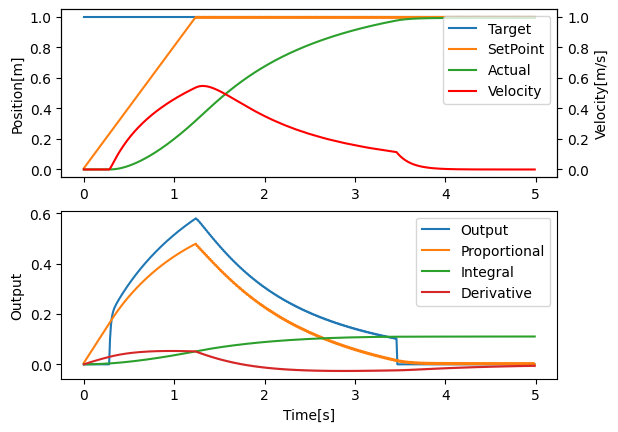

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# モデル設定
dt = 10e-3 # 制御周期(100Hz = 10ms)
t = np.arange(0, 5, dt) # 時間(グラフの横軸) 0~10まで
target = np.full_like(t, 1) # 目標値

# PIDゲイン
kp = 0.7
ki = 0.1
kd = 0.15
max_out = 0.7

def saturate(x):
  return max_out if x > max_out else -max_out if x < -max_out else x

# シミュレーション
position = np.zeros_like(t) # 状態出力
set_point = np.zeros_like(t) # 状態出力
velocity = np.zeros_like(t) # 速度
error = np.zeros_like(t)
integral = np.zeros_like(t)
derivative = np.zeros_like(t)
control = np.zeros_like(t) # 制御出力

for i in range(len(t)):
  # 二自由度制御
  dtag = 0.8 * dt
  set_point[i] = set_point[i-1] + (dtag if target[i] - set_point[i-1] > 0 else -dtag if target[i] - set_point[i-1] < 0 else target[i] - set_point[i-1])
  error[i] = set_point[i] - position[i-1]
  integral[i] = integral[i-1] + error[i] * dt
  # anti-windup
  integral[i] = saturate(integral[i] * ki) / ki if ki != 0 else 0
  derivative[i] = (error[i] - error[i-1]) / dt if i > 0 else 0
  # 不完全微分
  derivative[i] = derivative[i] + (derivative[i-1] - derivative[i]) * 0.99
  control[i] = kp * error[i] + ki * integral[i] + kd * derivative[i]
  # 制御出力のローパスフィルタ
  control[i] = control[i] + (control[i-1] - control[i]) / 2
  # 制御出力の飽和 70%上限
  control[i] = saturate(control[i])
  # モデルの再現
  control[i] = 0 if abs(control[i]) < 0.1 else control[i] # 制御出力のデッドゾーン
  velocity[i] = velocity[i-1] + (control[i] - velocity[i-1]) / 16 # 速度の遅れ
  position[i] = position[i-1] + velocity[i] * dt # 変位 = 速度の積分

fig, axes = plt.subplots(2, 1)

control_input = axes[1]
control_output = axes[0]
control_output_right = control_output.twinx()

control_output.plot(t, target, label='Target')
control_output.plot(t, set_point, label='SetPoint')
control_output.plot(t, position, label='Actual')
control_output_right.plot(t, velocity, label='Velocity', color='red')
h1, l1 = control_output.get_legend_handles_labels()
h2, l2 = control_output_right.get_legend_handles_labels()
control_output.legend(h1+h2, l1+l2, loc='upper right')
control_output_right.set_ylim(control_output.get_ylim())
control_output.set_ylabel('Position[m]')
control_output_right.set_ylabel('Velocity[m/s]')

control_input.plot(t, control, label='Output')
control_input.plot(t, error * kp, label='Proportional')
control_input.plot(t, integral * ki, label='Integral')
control_input.plot(t, derivative * kd, label='Derivative')
control_input.legend()
control_input.set_ylabel('Output')

control_input.set_xlabel('Time[s]')
plt.show()
